# Introduction to Networkx

`Networkx` (typically imported as `nx`) is one of the most common Python packages for working with network data. You can find the [documentation here](https://networkx.org/documentation/stable/index.html). To get us started here are some networkx basics:

In [1]:
# import the networkx package
import networkx as nx

In [2]:
# create an empty, undirected network 
G = nx.Graph()

In [3]:
# add a node
G.add_node('a')
print(G.nodes())

['a']


In [4]:
# add an edge, this will automatically add missing nodes
G.add_edge('b', 'c')
print(G.nodes())
print(G.edges())

['a', 'b', 'c']
[('b', 'c')]


In [5]:
# add an edge with weight
G.add_edge('a', 'c', weight=1)

# to access edge (or node) attributes, you need to set data=True. Eg:
print('Just the node-node pairs:')
print(G.edges())

print('\nSetting data=True to get edge attributes')
print(G.edges(data=True))

Just the node-node pairs:
[('a', 'c'), ('b', 'c')]

Setting data=True to get edge attributes
[('a', 'c', {'weight': 1}), ('b', 'c', {})]


For edges where the weight is specified, we can access that using using the nodes and attribute name as keys. In an undirected network, it doesn't matter which order you put the node-keys in:

In [6]:
print(G['a']['c']['weight'])
print(G['c']['a']['weight'])

1
1


Note that we didn't specify a weight when we added the edge `b - c`. By default, no attributes are specified, so we can't access the "weight" of this edge without adding "weight" as an attribute first. Eg, the following code with throw an error:

In [7]:
print(G['b']['c']['weight'])

KeyError: 'weight'

But, can use the dictionary method `.setdefault()` to ensure the attribute is added if we need to. More on dictionaries soon!

In [8]:
# increment weights
for i, j in G.edges():  # for every edge
    G[i][j].setdefault('weight', 0) # set the default weight to zero
    G[i][j]['weight'] += 1 # NOW every edge has a weight so we can do things with it
    
print(G.edges(data=True)) # print with weights

[('a', 'c', {'weight': 2}), ('b', 'c', {'weight': 1})]


Note: You can add arbitrary node or edge attributes. There is no set list of attribute names you have to draw from. Attributes can be a range of types.

In [9]:
# add attributes to existing nodes
nx.set_node_attributes(G, values={'a': [1, 2, 3]}, name='records')
nx.set_node_attributes(G, values={'b': 1}, name='count')
nx.set_node_attributes(G, values={'c': 'sunny'}, name='weather')

print(G.nodes(data=True))

[('a', {'records': [1, 2, 3]}), ('b', {'count': 1}), ('c', {'weather': 'sunny'})]


# Text and Networks
# Example 1: Hashtag co-occurance

Nodes are the hashtags which appear in a given set of tweets. Edges represent if two hashtags co-occur in the same tweet. Weight of edge indicates number of times they co-occur.

In [10]:
# packages we will need for this example
import json # loading data
import networkx as nx # for networks!
import numpy as np # for math
import itertools as it # fancy iteration
import matplotlib.pyplot as plt # visualizations

In [11]:
filename = 'tweets.json'

with open(filename, 'r') as fp:
    tweets = json.loads(fp.read())
    
print('{} tweets loaded'.format(len(tweets)))

59967 tweets loaded


## Data format and background
These tweets were collected from the Twitter API using a list of "Black Lives Matter" related keywords. All tweets were made between in April and May of 2021. The dataset has already been trimmed to only include tweets with at least one hashtag. All collected tweets were public on Twitter at the time of data collection. Content warning: no additional filtering has been done and the dataset may include vile and offensive language.

**Data Format** The Twitter API returns objects in JSON format. Here, using `json.loads()` reads the data into the object `tweets`, which is a list of **dictionary** objects. This data format has a key, value format -- eg, keys are used to "look up" values in the dictionary. In other words, if we were to print out `tweets` it would be a list that would look something like this:
```
tweets = [{tweet 1 dictionary},
          {tweet 2 dictionary},
          ...
          {tweet n dictionary}
          ]
```

Since `tweets` is a list, we can find out how many tweets it contains using `len()` (eg, equivalent of "length" for R users). We can access a specific tweet using it's index (Note: the first element is at index 0). or by iterating over the list (eg: `for tweet in tweets:`).

Let's look at the first tweet in the dataset:

In [12]:
tweets[0]

{'text': '@MrAndyNgo But #BLM is all about peace according to @VP.',
 'entities': {'hashtags': [{'start': 15, 'end': 19, 'tag': 'BLM'}],
  'mentions': [{'start': 0, 'end': 10, 'username': 'MrAndyNgo'},
   {'start': 52, 'end': 55, 'username': 'VP'}]},
 'context_annotations': [{'domain': {'id': '10',
    'name': 'Person',
    'description': 'Named people in the world like Nelson Mandela'},
   'entity': {'id': '875006493984149509',
    'name': 'Kamala Harris',
    'description': 'US Senator Kamala Harris (CA)'}},
  {'domain': {'id': '10',
    'name': 'Person',
    'description': 'Named people in the world like Nelson Mandela'},
   'entity': {'id': '1161294453560098822', 'name': 'Andy Ngo'}},
  {'domain': {'id': '35',
    'name': 'Politician',
    'description': 'Politicians in the world, like Joe Biden'},
   'entity': {'id': '875006493984149509',
    'name': 'Kamala Harris',
    'description': 'US Senator Kamala Harris (CA)'}}],
 'public_metrics': {'retweet_count': 1,
  'reply_count': 0,


Here, we see that each tweet dictionary contains a lot of information about the tweet, which is all contained in nested dictionary objects. We can use `[key]` to access a given key-value pair (where the value may be a dictionary!) and we can use `.keys()` to see all available keys. Eg, the top-level keys available for this tweet are:

In [13]:
tweet = tweets[0] # save this as tweet of interest
tweet.keys()

dict_keys(['text', 'entities', 'context_annotations', 'public_metrics', 'author_id', 'id', 'in_reply_to_user_id', 'created_at', 'lang', 'referenced_tweets', 'conversation_id'])

While we could work directly with the `text` Twitter makes hashtag analysis particularly easy by indentifying the specific hashtags which exist in the tweet. Note that field *only* stores items which were explicitly denoted as hashtags (using '#'). Eg, given the text:

```
The hashtag for BLM is #BLM
```
Only the second reference of BLM will count as a hashtag. Something to think about if you're working with Twitter data: **which string do you want to be considered as nodes?**

Hashtags included in a tweets are stored under entities -> hashtags. Hashtags will be stored in a list with a record of the tag itself and where it appears in the tweet. Eg:

In [14]:
tweet['entities']['hashtags']

[{'start': 15, 'end': 19, 'tag': 'BLM'}]

In [15]:
# start : 15 and end : 19 are tell you exactly where the hashtag can be found in the tweet:
tweet['text'][15:19]

'#BLM'

In [16]:
# can extract just the 'tag' information using a list comprehension:
tag_details = tweet['entities']['hashtags']  

# only key the 'tag' part of each hashtag
hashtags = [details['tag'] for details in tag_details]

print(hashtags)

['BLM']


We can also retrieve hashtags "the old fashioned way" by iterating over word in the tweet and looking for words that start with the '#' symbol. 

Note that in Python `split()` can be used to split a string into a list, similar to the R function strsplit(tweet, " "). By default, `split()` will split on spaces, but you can pass any character/collection of characters, eg `split(',')` or `split(' and ')`.

In [17]:
# just show spliting the string and iterating over each word
for word in tweet['text'].split():
    print(word)

@MrAndyNgo
But
#BLM
is
all
about
peace
according
to
@VP.


In [18]:
# get hashtags

hashtags = list() # empty list to store hashtags

for word in tweet['text'].split(): # iterate over each word
    if word[0] == '#': # if the 0-index element is #
        hashtags.append(word) # keep it as a hashtag
        
print(hashtags)

['#BLM']


## Making a network
To turn this into a hashtag co-occurance network we need to iterate through every tweet, saving every hashtag as a node and saving an edge between every pair of hashtags. If we see a hashtag pair more than once, we'll increase the weight of that edge.

We'll store our network data using `Networkx` (which we've imported as `nx`). You can find the [documentation here](https://networkx.org/documentation/stable/index.html).

In [19]:
G = nx.Graph() # init empty network

for tweet in tweets: # iterate over all tweets
    
    # note: all tweets in this dataset have hashtags
    tag_details = tweet['entities']['hashtags']  
    
    # only key the 'tag' part of each hashtag
    hashtags = [details['tag'] for details in tag_details]
    
    # if there's only 1 hashtag, we have a node but no edge
    if len(hashtags) == 1:
        h1 = hashtags[0]
        G.add_node(h1) # add node (won't replace)
        G.nodes[h1].setdefault('count', 0)
        G.nodes[h1]['count'] += 1
        
    else:
        for h1, h2 in it.combinations(hashtags, 2):
            G.add_edge(h1, h2)
            G[h1][h2].setdefault('weight', 0)
            G[h1][h2]['weight'] += 1
            
            G.nodes[h1].setdefault('count', 0)
            G.nodes[h1]['count'] += 1
            
            G.nodes[h2].setdefault('count', 0)
            G.nodes[h2]['count'] += 1
            
print('{} nodes (hashtags) found'.format(len(G)))

34649 nodes (hashtags) found


### Simple Network Analysis

In [20]:
# we can retrieve the weighted degree distribution using:
degrees = dict(G.degree(weight='weight'))

# this will return a dictionary where the keys are hashtags and the values are the degree
# {'BlackLivesMatter': 68290, 'BLM': 47576}

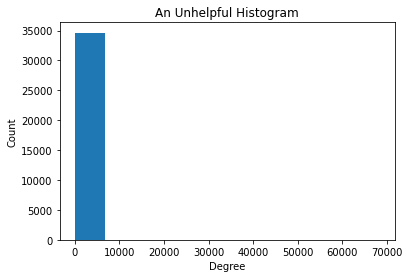

In [21]:
# Many networks have a heavy tailed degree distribution, which makes typical histograms not very helpful

plt.hist(degrees.values())
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('An Unhelpful Histogram')
plt.show()

In [22]:
# instead, will bin our data and look at it on log-log plot

# first, a function for binning our data

def binning(data,nb=50,log=True):
    # Seperate a vector of data into linear or log bins

    # Input:
    #   data : a vector of data
    #   bins : the number of bins to output (default: 50) 
    #   log : whether to log bin the data (default: True)

    # Output:
    #   x : the the midpoint of each bin
    #   y: the height of each bin 

    # coerce data to list
    data = list(data)
    
    # 1. find the data's upper and lower bounds
    lower_bound = min(data)
    upper_bound = max(data) + 1

    # 2. Define bins
    if log:
        lower_bound = np.log10(lower_bound) if lower_bound > 0 else 0
        upper_bound = np.log10(upper_bound)
        bins = np.logspace(lower_bound, upper_bound, nb)

    else:
        bins = np.linspace(lower_bound, upper_bound, nb)
    
    # 3. Compute the midpoint of each bin
    x = bins[1:] - np.diff(bins) / 2.0 

    # 4. Compute the height of each bin
    y, __ = np.histogram(data, 
                         weights=np.ones(len(data))/len(data),
                         bins = bins, 
                         density=False)

    return x, y

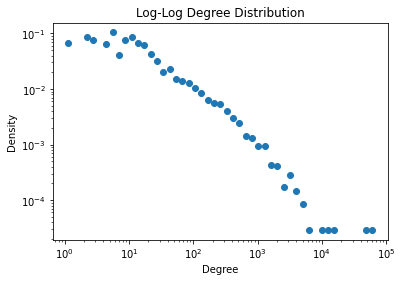

In [23]:
x, y = binning(degrees.values())

plt.loglog(x, y, marker='o', linewidth=0)
plt.xlabel('Degree')
plt.ylabel('Density')
plt.title('Log-Log Degree Distribution')
plt.show()

### Look at top hashtags

In [24]:
# the items in the degrees dictionary will be stored in arbitrary order

for i, (node, degree) in enumerate(degrees.items()):
    if i < 5:
        print(node, degree)

BLM 47576
art 2564
artists 763
BlackLivesMatter 68290
CrisisArt 734


In [25]:
# we can sort this form highest to lowest using:
sorted_degrees = dict(sorted(dict(degrees).items(), key=lambda item: item[1], reverse=True))

for i, (node, degree) in enumerate(sorted_degrees.items()):
    if i < 10:
        print(node, degree)

BlackLivesMatter 68290
BLM 47576
blm 15951
blacklivesmatter 13136
GeorgeFloyd 10069
LGBTQ 6560
racism 4793
Resist 4579
DaunteWright 4542
FBR 4216


### Removing capitalization
What if we want "BLM" and "blm" to be the same node? We could adjust for this in our current network, but it's actually easier to just rebuild the network and force everything to be lower case

In [26]:
G = nx.Graph() # init empty network

for tweet in tweets: # iterate over all tweets
    
    # note: all tweets in this dataset have hashtags
    tag_details = tweet['entities']['hashtags']  
    
    ##### CHANGE: Make all hashtags lower case
    hashtags = [details['tag'].lower() for details in tag_details]
    
    #### NEW: Coerce to set (unique items) and then back to list
    # Preventsself loops based on different capitalization
    hashtags = list(set(hashtags))
    
    # if there's only 1 hashtag, we have a node but no edge
    if len(hashtags) == 1:
        h1 = hashtags[0]
        G.add_node(h1) # add node (won't replace)
        G.nodes[h1].setdefault('count', 0) 
        G.nodes[h1]['count'] += 1
        
    else:
        for h1, h2 in it.combinations(hashtags, 2):
            G.add_edge(h1, h2)
            G[h1][h2].setdefault('weight', 0)
            G[h1][h2]['weight'] += 1
            
            G.nodes[h1].setdefault('count', 0)
            G.nodes[h1]['count'] += 1
            
            G.nodes[h2].setdefault('count', 0)
            G.nodes[h2]['count'] += 1
            
print('{} nodes (hashtags) found'.format(len(G)))

29387 nodes (hashtags) found


In [27]:
# lets look at the top degrees again
degrees = dict(G.degree(weight='weight'))
sorted_degrees = dict(sorted(dict(degrees).items(), key=lambda item: item[1], reverse=True))

for i, (node, degree) in enumerate(sorted_degrees.items()):
    if i < 10:
        print(node, degree)

blacklivesmatter 81479
blm 61951
georgefloyd 11475
lgbtq 7836
racism 6537
resist 5164
dauntewright 4877
antifa 4679
covid19 4532
alllivesmatter 4514


### Note: there is no "ideal" way to deduplicate / disambiguate
By making all text lower case, we're now treating "BLM" and "blm" as the same hashtag, but we're still treating "blm" and "blacklivesmatter" as different hashtags. Are they different? Are they the same? By doing a qualitative analysis of our hashtags, we can identify words which we belive are refering to the same "concept" but there will always be a degree of researcher subjectivity in making choices about what counts as the same vs different.

### Network visualization

In [28]:
# For vizualiation purposes, we'll make a subgraph with just the 50 highest degree nodes
top = list(sorted_degrees.keys())[:50]
sub = G.subgraph(top) # induce subgraph from top nodes

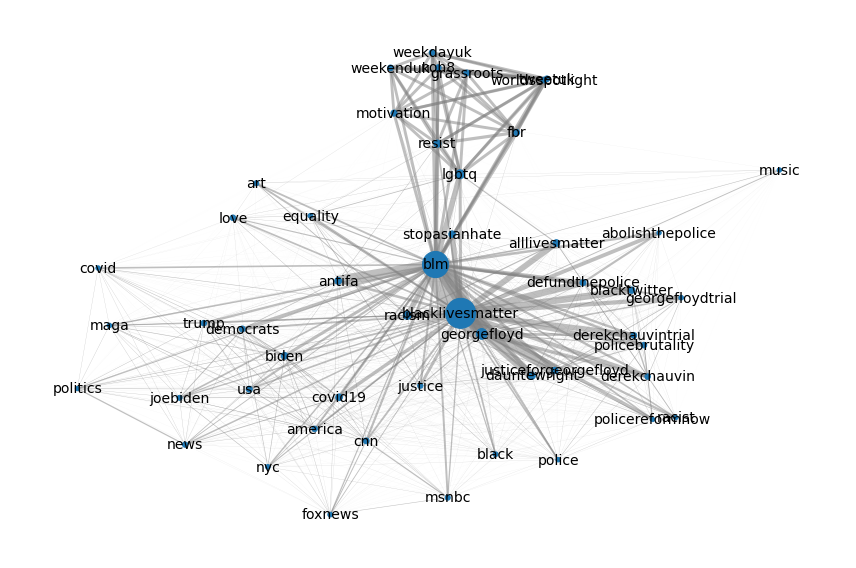

In [32]:
plt.figure(figsize=(12,8))
pos = nx.spring_layout(sub, seed=42) 

# nodes
counts = nx.get_node_attributes(G, 'count')
node_size = [counts[node]//10**2 for node in sub.nodes()]
nx.draw_networkx_nodes(sub, pos, node_size=node_size)

# edges
edge_width = [details['weight']/10**2 for i, j, details in sub.edges(data=True)]
nx.draw_networkx_edges(sub, pos, width=edge_width, 
                       edge_color='grey', alpha=0.5)


# labels
nx.draw_networkx_labels(sub, pos, 
                        font_size=14)

ax = plt.gca()
ax.margins(0.1)
plt.axis("off")
plt.tight_layout()
plt.show()

# Example 2: Named entities in congressional record

Here, we'll take an html text file reflecting a single issue (day) of the [US Congressional Record](https://www.congress.gov/congressional-record). This document reports on all business conducted by both the House and the Senate on a given day. Our data is from June 11, 2021.

We'll assume that we don't know much about the data structure. We want to learn something about how members of congress interact with each other, but we're not sure exactly how this will be presented in the data.

We'll use SpaCy's English language model. See [SpaCy's documentation](https://spacy.io/models) for a list of other language models available. For the purposes of today's excercises we'll use the "small" language model which takes up less memory/disk space but which also contains a smaller vocabulary (eg, known words) and information. For most research, I recommend using the large language model for the most accurate results.

### Text processing and cleaning

In [33]:
# packages we will need for this example
import spacy # for text parsing and tagging
from bs4 import BeautifulSoup # for dealing with html
import networkx as nx # for networks
import numpy as np # for math
import itertools as it # fancy iteration
import matplotlib.pyplot as plt # visualizations

nlp = spacy.load('en_core_web_sm')

# for better performance use the large language model:
# nlp = spacy.load('en_core_web_lg')
# Note this is not available on Google Colab

In [34]:
# load the text file
filename = 'CREC-2020-06-11.txt'

with open(filename, 'r') as fp:
    raw_text = fp.read()

In [35]:
# look at first 5k characters of text
raw_text[:5000]

'<html>\n<head>\n<title>Congressional Record, Volume 166 Issue 108 (Thursday, June 11, 2020)</title>\n</head>\n<body><pre>\n[Congressional Record Volume 166, Number 108 (Thursday, June 11, 2020)]\n[House]\n[Page H2379]\nFrom the Congressional Record Online through the Government Publishing Office [<a href="https://www.gpo.gov">www.gpo.gov</a>]\n\n\n             H O U S E  O F  R E P R E S E N T A T I V E S\n\n\nVol. 166\n\n\nWASHINGTON, THURSDAY, JUNE 11, 2020\n\nNo. 108\n\n\n</pre></body>\n</html>\n<html>\n<head>\n<title>Congressional Record, Volume 166 Issue 108 (Thursday, June 11, 2020)</title>\n</head>\n<body><pre>\n[Congressional Record Volume 166, Number 108 (Thursday, June 11, 2020)]\n[House]\n[Page H2379]\nFrom the Congressional Record Online through the Government Publishing Office [<a href="https://www.gpo.gov">www.gpo.gov</a>]\n\n[[Page H2379]]\n\nHouse of Representatives\n\n  The House met at 9 a.m. and was called to order by the Speaker pro \ntempore (Mr. Brown of Maryland

In [36]:
# strip html tags using beautiful soup
clean = BeautifulSoup(raw_text, 'html.parser').text

clean[:1000]

'\n\nCongressional Record, Volume 166 Issue 108 (Thursday, June 11, 2020)\n\n\n[Congressional Record Volume 166, Number 108 (Thursday, June 11, 2020)]\n[House]\n[Page H2379]\nFrom the Congressional Record Online through the Government Publishing Office [www.gpo.gov]\n\n\n             H O U S E  O F  R E P R E S E N T A T I V E S\n\n\nVol. 166\n\n\nWASHINGTON, THURSDAY, JUNE 11, 2020\n\nNo. 108\n\n\n\n\n\n\nCongressional Record, Volume 166 Issue 108 (Thursday, June 11, 2020)\n\n\n[Congressional Record Volume 166, Number 108 (Thursday, June 11, 2020)]\n[House]\n[Page H2379]\nFrom the Congressional Record Online through the Government Publishing Office [www.gpo.gov]\n\n[[Page H2379]]\n\nHouse of Representatives\n\n  The House met at 9 a.m. and was called to order by the Speaker pro \ntempore (Mr. Brown of Maryland).\n\n                          ____________________\n\n\n\n\n\n\nCongressional Record, Volume 166 Issue 108 (Thursday, June 11, 2020)\n\n\n[Congressional Record Volume 166, Numb

In [37]:
# turn into a Spacy document
doc = nlp(clean)
print(doc)



Congressional Record, Volume 166 Issue 108 (Thursday, June 11, 2020)


[Congressional Record Volume 166, Number 108 (Thursday, June 11, 2020)]
[House]
[Page H2379]
From the Congressional Record Online through the Government Publishing Office [www.gpo.gov]


             H O U S E  O F  R E P R E S E N T A T I V E S


Vol. 166


WASHINGTON, THURSDAY, JUNE 11, 2020

No. 108






Congressional Record, Volume 166 Issue 108 (Thursday, June 11, 2020)


[Congressional Record Volume 166, Number 108 (Thursday, June 11, 2020)]
[House]
[Page H2379]
From the Congressional Record Online through the Government Publishing Office [www.gpo.gov]

[[Page H2379]]

House of Representatives

  The House met at 9 a.m. and was called to order by the Speaker pro 
tempore (Mr. Brown of Maryland).

                          ____________________






Congressional Record, Volume 166 Issue 108 (Thursday, June 11, 2020)


[Congressional Record Volume 166, Number 108 (Thursday, June 11, 2020)]
[House]
[Page H237

In [38]:
# 'doc' is now a spacy document
type(doc)

spacy.tokens.doc.Doc

SpaCy now stores this text as essentially a series of "tokens". Tokens are strings of arbitrary length that form a
"building block" of a given language. They can be words, punctuation, white space, etc

In [39]:
# print first 10 tokens 
# Tokens includes white space!
for i, token in enumerate(doc):
    if i < 10:
        print(token.text)




Congressional
Record
,
Volume
166
Issue
108
(
Thursday


In [40]:
# we can also see how many total tokens there are using len()
print('The doc has {} tokens'.format(len(doc)))

The doc has 31727 tokens


SpaCy also stores information about each of these tokens. You can see a list of all available token attributes [here](https://spacy.io/api/token#attributes). Here are a few core ones:
* token.text : string of token
* token.lower_ : lowercase form of the token
* token.lemma_ : base form of token 
* token.pos_ : coarse-grained part-of-speech from the [Universal POS tag set](https://universaldependencies.org/docs/u/pos/)
* token.tag_ : fine-grained part-of-speech
* token.sentiment : sentiment (use carefully!!)
* token.is_stop : boolean indicating if stop word
* token.is_digit : boolean indicating if digit
* token.vector : word embedding (length 300 vector)

In [41]:
for i, token in enumerate(doc):
    if i > 1000 and i < 1010:
        print(token.text)
        print('  index in document: ', token.i)
        print('  lemma: ', token.lemma_)
        print('  Part of speech: ', token.pos_)
        print('  Stop word?', token.is_stop)
        print()

.
  index in document:  1001
  lemma:  .
  Part of speech:  PUNCT
  Stop word? False

The
  index in document:  1002
  lemma:  the
  Part of speech:  DET
  Stop word? True

Chair
  index in document:  1003
  lemma:  Chair
  Part of speech:  PROPN
  Stop word? False

announces
  index in document:  1004
  lemma:  announce
  Part of speech:  VERB
  Stop word? False

the
  index in document:  1005
  lemma:  the
  Part of speech:  DET
  Stop word? True

Speaker
  index in document:  1006
  lemma:  Speaker
  Part of speech:  PROPN
  Stop word? False

's
  index in document:  1007
  lemma:  's
  Part of speech:  PART
  Stop word? True



  index in document:  1008
  lemma:  

  Part of speech:  SPACE
  Stop word? False

appointment
  index in document:  1009
  lemma:  appointment
  Part of speech:  NOUN
  Stop word? False



In [42]:
# recover token from index
doc[1009]

appointment

### Working with named entities

We want to know something about members of Congress, but how do we know which words refer to the people we are interested in?

Use `.ents` to retieve all items labeled as entities. The SpaCy language model we loaded was trained on a large corpus of English language text and is able to somewhat accurately identify many named entitities (the large language model has an accuracy of about 85\%). For most datasets and research questions, **you should (1) verify the accuracy with a random, hand-coded sample, (2) expect to add domain-specific entities not included in SpaCy's model and (3) plan some process of name disambiguation.**

In [45]:
# get all entities in the doc
all_ents = doc.ents
print('{} entities found'.format(len(all_ents)))

3881 entities found


In [46]:
# prin the entity, its label and what character span it occurs in
# Does pretty well, but definitely some weird things in this output!
for ent in all_ents:
    print(ent.text, ent.label_)
    print('   starts at: {}, ends at: {}'.format(ent.start_char, ent.end_char))

166 CARDINAL
   starts at: 31, ends at: 34
Thursday, June 11, 2020 DATE
   starts at: 46, ends at: 69
166 CARDINAL
   starts at: 102, ends at: 105
108 CARDINAL
   starts at: 114, ends at: 117
Thursday, June 11, 2020 DATE
   starts at: 119, ends at: 142
the Congressional Record Online ORG
   starts at: 171, ends at: 202
the Government Publishing Office ORG
   starts at: 211, ends at: 243
166 CARDINAL
   starts at: 326, ends at: 329
WASHINGTON GPE
   starts at: 332, ends at: 342
THURSDAY GPE
   starts at: 344, ends at: 352
JUNE 11, 2020 DATE
   starts at: 354, ends at: 367
108 CARDINAL
   starts at: 373, ends at: 376
Congressional Record ORG
   starts at: 383, ends at: 403
166 CARDINAL
   starts at: 412, ends at: 415
Thursday, June 11, 2020 DATE
   starts at: 427, ends at: 450
166 CARDINAL
   starts at: 483, ends at: 486
108 CARDINAL
   starts at: 495, ends at: 498
Thursday, June 11, 2020 DATE
   starts at: 500, ends at: 523
the Congressional Record Online ORG
   starts at: 552, ends at:

P.L. GPE
   starts at: 37815, ends at: 37819
116-123 CARDINAL
   starts at: 37825, ends at: 37832
P.L. GPE
   starts at: 37990, ends at: 37994
the Guam World LOC
   starts at: 38142, ends at: 38156
War II Loyalty Recognition Act EVENT
   starts at: 38162, ends at: 38192
P.L. GPE
   starts at: 38199, ends at: 38203
116-132 PRODUCT
   starts at: 38204, ends at: 38211
61,183 CARDINAL
   starts at: 38425, ends at: 38431
2019 DATE
   starts at: 38689, ends at: 38693
P.L. GPE
   starts at: 38703, ends at: 38707
883,208                  530,066                         PRODUCT
   starts at: 38774, ends at: 38830
Further Consolidated PERSON
   starts at: 38874, ends at: 38894
2020 DATE
   starts at: 39008, ends at: 39012
P.L. GPE
   starts at: 39030, ends at: 39034
1,768,228 CARDINAL
   starts at: 39251, ends at: 39260
2,532,342 CARDINAL
   starts at: 39377, ends at: 39386
1,829,411 CARDINAL
   starts at: 39402, ends at: 39411
3,876,565 CARDINAL
   starts at: 39679, ends at: 39688
3,779,711 CAR

the House of Representatives ORG
   starts at: 68355, ends at: 68383
the Congressional Budget Act ORG
   starts at: 68419, ends at: 68447
the
  Congressional Budget Act ORG
   starts at: 68564, ends at: 68594
1974 DATE
   starts at: 68598, ends at: 68602
Outlays                  Revenues
 
Emergency Requirements WORK_OF_ART
   starts at: 68961, ends at: 69019
2020 DATE
   starts at: 69158, ends at: 69162
P.L. GPE
   starts at: 69164, ends at: 69168
116-142 CARDINAL
   starts at: 69174, ends at: 69181
Congressional Record ORG
   starts at: 69693, ends at: 69713
166 CARDINAL
   starts at: 69722, ends at: 69725
Thursday, June 11, 2020 DATE
   starts at: 69737, ends at: 69760
166 CARDINAL
   starts at: 69793, ends at: 69796
108 CARDINAL
   starts at: 69805, ends at: 69808
Thursday, June 11, 2020 DATE
   starts at: 69810, ends at: 69833
the Congressional Record Online ORG
   starts at: 69862, ends at: 69893
the Government Publishing Office ORG
   starts at: 69902, ends at: 69934
4(b CARDINA

the Committee on Transportation and Infrastructure ORG
   starts at: 92455, ends at: 92505
the Management and Program Analyst ORG
   starts at: 92534, ends at: 92568
FAA ORG
   starts at: 92576, ends at: 92579
Department of Transportation ORG
   starts at: 92581, ends at: 92609
the 
     Department's ORG
   starts at: 92624, ends at: 92646
The 
     Boeing Company Airplanes ORG
   starts at: 92687, ends at: 92721
39-19856 DATE
   starts at: 92801, ends at: 92809
AD 2020-04-19 DATE
   starts at: 92811, ends at: 92824
May 22, 2020 DATE
   starts at: 92858, ends at: 92870
5 CARDINAL
   starts at: 92884, ends at: 92885
Sec PERSON
   starts at: 92933, ends at: 92936
251 CARDINAL
   starts at: 92938, ends at: 92941
110 CARDINAL
   starts at: 92944, ends at: 92947
868 CARDINAL
   starts at: 92954, ends at: 92957
the Committee on Transportation and Infrastructure ORG
   starts at: 92969, ends at: 93019
the Management and Program Analyst ORG
   starts at: 93048, ends at: 93082
FAA ORG
   starts

May 22, 2020 DATE
   starts at: 103431, ends at: 103443
5 CARDINAL
   starts at: 103457, ends at: 103458
Sec PERSON
   starts at: 103506, ends at: 103509
251 CARDINAL
   starts at: 103511, ends at: 103514
110 CARDINAL
   starts at: 103517, ends at: 103520
868 CARDINAL
   starts at: 103527, ends at: 103530
the 
     Committee on Transportation and Infrastructure ORG
   starts at: 103536, ends at: 103592
the Management and Program Analyst ORG
   starts at: 103621, ends at: 103655
FAA ORG
   starts at: 103663, ends at: 103666
Department of Transportation ORG
   starts at: 103668, ends at: 103696
the 
     Department's ORG
   starts at: 103711, ends at: 103733
Standard Instrument Approach 
     Procedures ORG
   starts at: 103748, ends at: 103793
Takeoff Minimums ORG
   starts at: 103799, ends at: 103815
Obstacle Departure 
     Procedures WORK_OF_ART
   starts at: 103820, ends at: 103855
31302 CARDINAL
   starts at: 103895, ends at: 103900
3896 CARDINAL
   starts at: 103935, ends at: 1039

Florida GPE
   starts at: 117754, ends at: 117761
Huffman PERSON
   starts at: 117767, ends at: 117774
Pocan PERSON
   starts at: 117780, ends at: 117785
Ocasio-Cortez ORG
   starts at: 117805, ends at: 117818
Velazquez PERSON
   starts at: 117824, ends at: 117833
Sean Patrick PERSON
   starts at: 117839, ends at: 117851
Maloney PERSON
   starts at: 117866, ends at: 117873
New York GPE
   starts at: 117877, ends at: 117885
McGovern PERSON
   starts at: 117891, ends at: 117899
DeGette PERSON
   starts at: 117905, ends at: 117912
Price PERSON
   starts at: 117943, ends at: 117948
North Carolina GPE
   starts at: 117952, ends at: 117966
Larsen PERSON
   starts at: 117972, ends at: 117978
Washington GPE
   starts at: 117996, ends at: 118006
Kim PERSON
   starts at: 118016, ends at: 118019
H.R. 7164 ORG
   starts at: 118029, ends at: 118038
Defense ORG
   starts at: 118075, ends at: 118082
the Department of Defense ORG
   starts at: 118187, ends at: 118212
the United States GPE
   starts at

the Congressional Record Online ORG
   starts at: 138058, ends at: 138089
the Government Publishing Office ORG
   starts at: 138098, ends at: 138130
PALMER PERSON
   starts at: 138164, ends at: 138170
Congress ORG
   starts at: 138197, ends at: 138205
Article 1, Section 8 LAW
   starts at: 138286, ends at: 138306
Congress ORG
   starts at: 138328, ends at: 138336
Taxes ORG
   starts at: 138373, ends at: 138378
Congressional Record ORG
   starts at: 138420, ends at: 138440
166 CARDINAL
   starts at: 138449, ends at: 138452
Thursday, June 11, 2020 DATE
   starts at: 138464, ends at: 138487
166 CARDINAL
   starts at: 138520, ends at: 138523
108 CARDINAL
   starts at: 138532, ends at: 138535
Thursday, June 11, 2020 DATE
   starts at: 138537, ends at: 138560
the Congressional Record Online ORG
   starts at: 138589, ends at: 138620
the Government Publishing Office ORG
   starts at: 138629, ends at: 138661
STANTON PERSON
   starts at: 138695, ends at: 138702
Congress ORG
   starts at: 138729,

   starts at: 152899, ends at: 152922
Writings PERSON
   starts at: 153047, ends at: 153055
the supreme Court ORG
   starts at: 153116, ends at: 153133
War EVENT
   starts at: 153201, ends at: 153204
Reprisal ORG
   starts at: 153234, ends at: 153242
two Years DATE
   starts at: 153420, ends at: 153429
Navy ORG
   starts at: 153464, ends at: 153468
the Service of the United States ORG
   starts at: 153842, ends at: 153874
States GPE
   starts at: 153899, ends at: 153905
Militia PERSON
   starts at: 153993, ends at: 154000
Congress ORG
   starts at: 154049, ends at: 154057
District GPE
   starts at: 154158, ends at: 154166
Miles PERSON
   starts at: 154186, ends at: 154191
States GPE
   starts at: 154239, ends at: 154245
Congress ORG
   starts at: 154275, ends at: 154283
the Seat of the Government of the United 
     States PRODUCT
   starts at: 154292, ends at: 154345
Authority ORG
   starts at: 154368, ends at: 154377
State ORG
   starts at: 154451, ends at: 154456
the Erection of For

   starts at: 161876, ends at: 161885
Granger PERSON
   starts at: 161891, ends at: 161898
Banks PERSON
   starts at: 161904, ends at: 161909
Nadler ORG
   starts at: 161921, ends at: 161927
Courtney PERSON
   starts at: 161933, ends at: 161941
Steube PERSON
   starts at: 161947, ends at: 161953
Stauber PERSON
   starts at: 161959, ends at: 161966
Roby PERSON
   starts at: 161980, ends at: 161984
Keller PERSON
   starts at: 161990, ends at: 161996
Stewart PERSON
   starts at: 162002, ends at: 162009
Rogers PERSON
   starts at: 162015, ends at: 162021
Alabama GPE
   starts at: 162025, ends at: 162032
Perlmutter PERSON
   starts at: 162044, ends at: 162054
Comer PERSON
   starts at: 162064, ends at: 162069
Doggett PERSON
   starts at: 162093, ends at: 162100
Courtney PERSON
   starts at: 162124, ends at: 162132
H.R. 1574 DATE
   starts at: 162141, ends at: 162150
Heck PERSON
   starts at: 162156, ends at: 162160
Cooper PERSON
   starts at: 162166, ends at: 162172
Larsen PERSON
   starts 

Lee PERSON
   starts at: 167354, ends at: 167357
California GPE
   starts at: 167361, ends at: 167371
Turner PERSON
   starts at: 167395, ends at: 167401
Espaillat PERSON
   starts at: 167425, ends at: 167434
Ocasio-Cortez PERSON
   starts at: 167440, ends at: 167453
Ted Lieu PERSON
   starts at: 167459, ends at: 167467
California GPE
   starts at: 167477, ends at: 167487
Lowenthal PERSON
   starts at: 167493, ends at: 167502
Carolyn B. Maloney PERSON
   starts at: 167509, ends at: 167527
New 
     York GPE
   starts at: 167531, ends at: 167545
Huffman PERSON
   starts at: 167551, ends at: 167558
Johnson PERSON
   starts at: 167564, ends at: 167571
Georgia GPE
   starts at: 167575, ends at: 167582
Pressley PERSON
   starts at: 167592, ends at: 167600
Adams PERSON
   starts at: 167624, ends at: 167629
H.R. 6621 PERSON
   starts at: 167638, ends at: 167647
Stewart PERSON
   starts at: 167653, ends at: 167660
Spanberger PERSON
   starts at: 167684, ends at: 167694
DelBene PERSON
   starts

   starts at: 172973, ends at: 172977
Rose PERSON
   starts at: 172989, ends at: 172993
New York GPE
   starts at: 172997, ends at: 173005
DeGette PERSON
   starts at: 173015, ends at: 173022
H.R. 7094 PERSON
   starts at: 173031, ends at: 173040
Bishop PERSON
   starts at: 173046, ends at: 173052
Utah GPE
   starts at: 173056, ends at: 173060
H.R. 7096 PERSON
   starts at: 173069, ends at: 173078
Lawrence PERSON
   starts at: 173085, ends at: 173093
Khanna PERSON
   starts at: 173102, ends at: 173108
Johnson PERSON
   starts at: 173132, ends at: 173139
South Dakota GPE
   starts at: 173143, ends at: 173155
Smith PERSON
   starts at: 173164, ends at: 173169
Nebraska GPE
   starts at: 173179, ends at: 173187
H.R. 7111 PERSON
   starts at: 173196, ends at: 173205
Lamb PERSON
   starts at: 173211, ends at: 173215
Axne PERSON
   starts at: 173240, ends at: 173244
Case PERSON
   starts at: 173250, ends at: 173254
Casten of Illinois PERSON
   starts at: 173260, ends at: 173278
Craig PERSON
 

Green PERSON
   starts at: 175703, ends at: 175708
Texas GPE
   starts at: 175712, ends at: 175717
Hayes PERSON
   starts at: 175724, ends at: 175729
Lowenthal PERSON
   starts at: 175735, ends at: 175744
Castor PERSON
   starts at: 175756, ends at: 175762
Florida GPE
   starts at: 175766, ends at: 175773
San Nicolas PERSON
   starts at: 175779, ends at: 175790
Omar PERSON
   starts at: 175796, ends at: 175800
Hastings PERSON
   starts at: 175812, ends at: 175820
Rush PERSON
   starts at: 175826, ends at: 175830
Wilson PERSON
   starts at: 175840, ends at: 175846
Florida GPE
   starts at: 175850, ends at: 175857
H. Res PERSON
   starts at: 175866, ends at: 175872
992 CARDINAL
   starts at: 175874, ends at: 175877
Meeks PERSON
   starts at: 175883, ends at: 175888
H. Res PERSON
   starts at: 175897, ends at: 175903
994 CARDINAL
   starts at: 175905, ends at: 175908
Malinowski PERSON
   starts at: 175914, ends at: 175924
Kaptur PERSON
   starts at: 175933, ends at: 175939
Congressional R

In [47]:
# Let's filter to keep just the items that are labeled as "PERSON"
# Note: SpaCy "token" objects are unique, 
# if we want a unique list of names, we need to at the .text of a token

# try 1: keeping tokens
people = set()

for ent in all_ents:
    if ent.label_ == 'PERSON':
        people.add(ent) # keep the token object
        
print('{} unique people tokens founds'.format(len(people)))

# try 2: keeping just text
people = set()

for ent in all_ents:
    if ent.label_ == 'PERSON':
        people.add(ent.text) # keep just the text
        
print('{} unique people tokens founds'.format(len(people)))

1166 unique people tokens founds
477 unique people tokens founds


In [48]:
# look at what we get...
people

{'4420',
 'ARRINGTON',
 'Adams',
 'Aderholt',
 'Airway V-61',
 'Albio Sires',
 'Alex Sadler',
 'Alexander Brockwehl',
 'Allred',
 'Ami Bera',
 'Anthony G. Brown',
 'Axne',
 'BANKS',
 'BEYER',
 'BISHOP',
 'BRENDAN F. BOYLE',
 'BROWN',
 'BUSTOS',
 'BUTTERFIELD',
 'Babin',
 'Bacon',
 'Balderson',
 'Banks',
 'Barragan',
 'Beatty',
 'Bera',
 'Beutler',
 'Beyer',
 'Bishop',
 'Blumenauer',
 'Blunt',
 'Blunt Rochester',
 'Bombardier',
 'Bonamici',
 'Bost',
 'Branch',
 'Brendan F. Boyle',
 'Brendan Shields',
 'Brindisi',
 'Brooks',
 'Brown',
 'Brownley',
 'Buchanan',
 'Budd',
 'Burchett',
 'Burgess',
 'Bustos',
 'Butterfield',
 'Butterfly Plant',
 'Byrne',
 'CARSON',
 'CHENEY',
 'CISNEROS',
 'CLARKE',
 'COVID-19',
 'Calvert',
 'Carbajal',
 'Cardenas',
 'Carlos Monje',
 'Caroline Campbell',
 'Carolyn B. Maloney',
 'Carson',
 'Carter',
 'Cartwright',
 'Case',
 'Casten',
 'Casten of Illinois',
 'Castor',
 'Castro Ramirez',
 'Catherine Feingold',
 'Chris Farrar',
 'Cicilline',
 'Cisneros',
 'Clarke

### Caveat / Disclaimer:
Working with text is hard! Many of these entities are _not_ people, and there's also a need to do entity linking / name disambiguation. Think about what types of validation / verification you need to put in place given your data set!

SpaCy allows you to connect your language to a [knowledge base]{https://spacy.io/api/kb/}, which can help with the task of disambiguation. This can be a custom knowledge base or an existing knowledge base -- eg, WikiData. 

Note also also that only names/titles are tagged as entities. Pronouns are not. If your research question has to do with how a text "talks about" someone, you may need to do additional analysis to identify non-named references to the person of interest.

In [49]:
# House resolutions are being tagged as people. ...Let's drop those.
people = dict()

for ent in all_ents:
    if ent.label_ == 'PERSON' and ent.text[:4] != 'H.R.':
        people.setdefault(ent.text, list())
        people[ent.text].append((ent.start_char, ent.end_char))
        
print('{} unique people tokens founds'.format(len(people)))

428 unique people tokens founds


In [50]:
# look at out dictionary
# keys are people and values are the character strings where they occur

# note again the need for disambiguation -- are "Brown" and "Anthony G. Brown" the same person?
people

{'Brown': [(765, 770),
  (112086, 112091),
  (165905, 165910),
  (166150, 166155),
  (166328, 166333),
  (167965, 167970),
  (170774, 170779)],
 'Anthony G. Brown': [(1421, 1437)],
 'Patrick J. Conroy': [(1984, 2001)],
 'BISHOP': [(3969, 3975)],
 'Catherine Feingold': [(4976, 4994)],
 'Frederick Gibson Ross': [(5024, 5045)],
 'J. REFUGIO': [(5429, 5439), (6013, 6023)],
 'Castro Ramirez': [(5597, 5611),
  (6184, 6198),
  (6604, 6618),
  (7935, 7949),
  (8502, 8516)],
 'J. Refugio Carreno Rojas': [(5616, 5640), (7223, 7247), (8521, 8545)],
 'Clerk': [(5648, 5653), (108415, 108420)],
 'Maria \n     Carmen': [(6165, 6183)],
 'J. Refugio Carreno': [(6203, 6221),
  (6628, 6646),
  (7953, 7971),
  (9215, 9233)],
 'Maria Carmen Castro': [(7185, 7204)],
 'Ramirez': [(7211, 7218)],
 'Maria Carmen': [(7922, 7934), (8483, 8495)],
 'Visa Number.--Upon': [(8398, 8416)],
 'Maria Carmen Castro Ramirez': [(9183, 9210)],
 'Jennifer Wheelock': [(13431, 13448), (51306, 51323)],
 'Raquel Spencer': [(13458,

### let's find sentences which mention people

In [51]:
# First, we get a list of all the start positions mentions of people
person_start = list()

for hr, char_list in people.items():
    for start, end in char_list:
        person_start.append(start)
        
person_start = sorted(person_start)
print(person_start[:10])

[765, 1421, 1984, 3969, 4976, 5024, 5429, 5597, 5616, 5648]


In [52]:
# iterate through the sentence in our document and keep sentences which include
# "the start of a person"
keep = list()

for sent in doc.sents:
    start = sent.start_char  # doc character index of sentence start
    end = sent.end_char  # doc character intexxt of sentence end
    
    for val in person_start: # for each index that represents the start of a "person"
        # keep this sentence if it's in this sentence spane
        if val >= start and val < end:
            keep.append(sent)
            
print('{} sentences kept'.format(len(keep)))

1101 sentences kept


In [53]:
# let's look at some of these sentences...
# Yes, I took an intentional slice here to show sentences of interest
for sent in keep[150:155]:
    print(sent)

By Mr. LATTA:
       H.R. 7147.
By Mr. WILSON of South Carolina (for himself and Ms. 
             Houlahan):
       H.R. 7148.
By Mr. WILSON of South Carolina (for himself and Ms. 
             Houlahan):
       H.R. 7148.

           By Mr. PALMER (for himself, Mr. Cook, Mr. Hagedorn, 
             Mrs. Wagner, Mr. Aderholt, Mr. Stivers, Mr. 
             Balderson, Mr. Perry, Mr. Gibbs, and Mr. Stewart):
       H.R. 7149.

           By Mr. PALMER (for himself, Mr. Cook, Mr. Hagedorn, 
             Mrs. Wagner, Mr. Aderholt, Mr. Stivers, Mr. 
             Balderson, Mr. Perry, Mr. Gibbs, and Mr. Stewart):
       H.R. 7149.


### PSA: 
Automated text analysis is **not** a replacement for qualitative analyis, but it can help identify texts/segements of interest from large corpora.

### Making a network
We'll make a co-sponsorship network where two people are connected if they are connected to the same bill. We'll use last names only and assume that all last names are unique. 

For example, given the sentence: "By Mr. WILSON of South Carolina (for himself and Ms. Houlahan)", we'll want a network that has: <br/> `edge: Wilson, Houlahan, weight = 1`

In [54]:
# FIRST, we'll find sentences that have the format we want
# specifically, we're looking for this format:
# "By [Mr./Mrs./Dr.] [Name]"

# find sentences of this format
cosponsored = list()

for sent in keep: # for every sentence we're keeping
    for i, token in enumerate(sent): # keep track of the token and it's position in the sentence
        if token.lemma_ == 'by' and i < len(sent)-2: # if the token is 'by' and we're not at the end of the sentence
            salutation_token = sent[i+1] # save the next token 
            name_token = sent[i+2] # and the token after that
            
            # check the two words immediate after "by"
            # keep this sentence if they're both labled as 'PROPN' (proper nouns)
            # and the "name" field is recognized as a person
            if salutation_token.pos_ == 'PROPN' and name_token.pos_ == 'PROPN' and name_token.ent_type_ == 'PERSON':
                cosponsored.append(sent)
                
print('{} Co-sponsorships sentences found'.format(len(cosponsored)))

321 Co-sponsorships sentences found


In [55]:
# look at the sentences we saved
cosponsored

[By Mr. DeFAZIO (for himself, Ms. Norton, and Mr. 
              Lipinski):
        H.R. 2.,
 By Mr. DeFAZIO (for himself, Ms. Norton, and Mr. 
              Lipinski):
        H.R. 2.,
 By Mr. DeFAZIO (for himself, Ms. Norton, and Mr. 
              Lipinski):
        H.R. 2.,
 By Mr. LATTA:
        H.R. 7147.,
 By Mr. WILSON of South Carolina (for himself and Ms. 
              Houlahan):
        H.R. 7148.,
 By Mr. WILSON of South Carolina (for himself and Ms. 
              Houlahan):
        H.R. 7148.,
 
            By Mr. PALMER (for himself, Mr. Cook, Mr. Hagedorn, 
              Mrs. Wagner, Mr. Aderholt, Mr. Stivers, Mr. 
              Balderson, Mr. Perry, Mr. Gibbs, and Mr. Stewart):
        H.R. 7149.,
 
            By Mr. PALMER (for himself, Mr. Cook, Mr. Hagedorn, 
              Mrs. Wagner, Mr. Aderholt, Mr. Stivers, Mr. 
              Balderson, Mr. Perry, Mr. Gibbs, and Mr. Stewart):
        H.R. 7149.,
 
            By Mr. PALMER (for himself, Mr. Cook, Mr. Hagedorn

### Make a network

For the purpose of this example will do some very simple (and innacurate name disambiguation rules. We'll assume that the last "name" token is the best label for person (eg, "ocasio-cortez" becomes "cortez") and that all matching last names refer to the same person (eg, every "brown" is the same person). The rules are definitely inducing errors in the data, but we'll use them here for demonstration purposes.

In [56]:
# now we'll make the network!
G = nx.Graph()

for sent in cosponsored:
    names = set()
    
    # get names from this sentence
    for i, token in enumerate(sent):
        next_token = sent[(i+1)%len(sent)]
        
        # take something as a name ONLY if:
        # 1 -- it is a proper noun (this trims weird things labeled as people)
        # 2 -- it is a "person" entity (what we're looking for!)
        # 3 -- the *next* token is NOT a person entity (we only want last name)
        if token.pos_ == 'PROPN' and token.ent_type_ == 'PERSON' and next_token.ent_type_ != 'PERSON' :
            names.add(token.lower_)
            
    # now, we have a set of nodes (people), let's add edges!
    # this code is basically the same as the hashtag code!
    
    names = list(names) # change to list for indexing
    
    # if there's only 1 person, we have a node but no edge
    if len(names) == 1:
        h1 = names[0]
        G.add_node(h1) # add node (won't replace)
        
    else:
        for h1, h2 in it.combinations(names, 2):
            G.add_edge(h1, h2)
            G[h1][h2].setdefault('weight', 0)
            G[h1][h2]['weight'] += 1
             
print('{} nodes (people) found'.format(len(G)))

175 nodes (people) found


In [57]:
# look at largest connected component
G_c = max(nx.connected_components(G), key=len) # nodes in largest connect component

sub = G.subgraph(G_c).copy() # induce subgraph from this

print(len(sub))

155


In [58]:
# load data about party affiliation
party = dict()

with open('party_affiliation.txt', 'r') as fp:
    for line in fp.readlines():
        line = line.strip().split('\t')
        
        party[line[0]] = line[1]

In [55]:
party

{'aderholt': 'R',
 'allred': 'D',
 'babin': 'R',
 'bacon': 'R',
 'balart': 'R',
 'balderson': 'R',
 'beatty': 'D',
 'bera': 'D',
 'beyer': 'D',
 'bishop': 'R',
 'blunt': 'R',
 'boyle': 'D',
 'brindisi': 'D',
 'brooks': 'R',
 'brown': 'D',
 'brownley': 'D',
 'buchanan': 'R',
 'budd': 'R',
 'burchett': 'R',
 'bustos': 'D',
 'butterfield': 'D',
 'calvert': 'R',
 'carson': 'D',
 'cicilline': 'D',
 'cisneros': 'D',
 'clarke': 'D',
 'cline': 'R',
 'coleman': 'D',
 'collins': 'R',
 'con': 'U',
 'conaway': 'R',
 'connolly': 'D',
 'cook': 'R',
 'cooper': 'D',
 'crawford': 'R',
 'dean': 'D',
 'defazio': 'D',
 'degette': 'D',
 'desaulnier': 'D',
 'dingell': 'D',
 'doyle': 'D',
 'engel': 'D',
 'escobar': 'D',
 'eshoo': 'D',
 'espaillat': 'D',
 'fitzpatrick': 'R',
 'fudge': 'D',
 'gaetz': 'R',
 'garcia': 'D',
 'gibbs': 'R',
 'gottheimer': 'D',
 'griffith': 'R',
 'haaland': 'D',
 'hagedorn': 'R',
 'harris': 'R',
 'hartzler': 'R',
 'hastings': 'D',
 'hayes': 'D',
 'hern': 'R',
 'holding': 'R',
 'hors

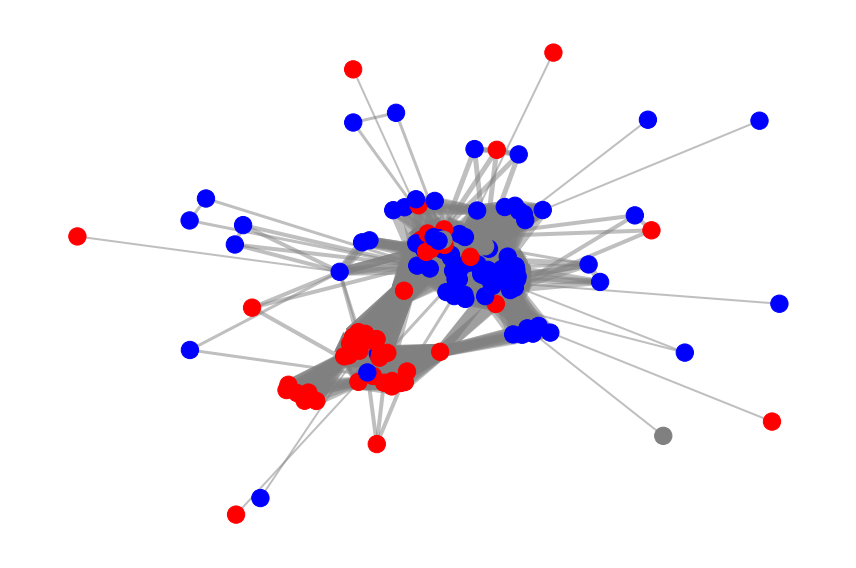

In [59]:
# visualize network
plt.figure(figsize=(12,8))
pos = nx.spring_layout(sub, seed=42) 

# nodes
color = list()
for node in sub.nodes():
    if party[node] == 'D':
        color.append('blue')
    elif party[node] == 'R':
        color.append('red')
    else:
        color.append('grey')
        
nx.draw_networkx_nodes(sub, pos, node_color = color)

# edges
edge_width = [details['weight'] for i, j, details in sub.edges(data=True)]
nx.draw_networkx_edges(sub, pos, width=edge_width, 
                       edge_color='grey', alpha=0.5)


# labels
# nx.draw_networkx_labels(sub, pos, 
#                        font_size=14)

ax = plt.gca()
ax.margins(0.1)
plt.axis("off")
plt.tight_layout()
plt.show()

# Example 3 -- Using Word Embeddings and Clustering
In this example, we'll demonstrate how word embeddings and clustering can be used to identify "similar" words and how grammatical structure can indicate connectivity.

**Note: the "small" language model that we're using should NOT be used for word embeddings.** We'll continue to use it here for the purposes of demonstration, but we'll see some warnings pop up and our results will be very weird/bad. Use the "large" language model when working with embeddings!

In [61]:
# packages we'll need
from sklearn.cluster import KMeans  # for clustering
from sklearn.decomposition import PCA # for dimensionality reduction
from kneed import KneeLocator # for identifying the "elbow"

In [62]:
# load plain text
filename = 'King_BirminghamJail.txt'

with open(filename, 'r') as fp:
    raw_text = fp.read()
    
# turn into a Spacy document
doc = nlp(raw_text)
print(doc)

"Letter from a Birmingham Jail [King, Jr.]"

16 April 1963
My Dear Fellow Clergymen:
While confined here in the Birmingham city jail, I came across your recent statement calling my present activities "unwise and untimely." Seldom do I pause to answer criticism of my work and ideas. If I sought to answer all the criticisms that cross my desk, my secretaries would have little time for anything other than such correspondence in the course of the day, and I would have no time for constructive work. But since I feel that you are men of genuine good will and that your criticisms are sincerely set forth, I want to try to answer your statement in what I hope will be patient and reasonable terms.

I think I should indicate why I am here in Birmingham, since you have been influenced by the view which argues against "outsiders coming in." I have the honor of serving as president of the Southern Christian Leadership Conference, an organization operating in every southern state, with headquarters i

In [64]:
# Let's only keep tokens which reflect "interesting" parts of speech. We'll arbitarily define that as:

POS_keep = set(['ADJ',
               'ADV',
               'NOUN',
               'PROPN',
               'VERB'])

# note: checking for membership in a set is faster than checking for membership in a list

In [65]:
# keep just tokens with these parts of speech
trimmed = list()

for token in doc:
    if token.pos_ in POS_keep:
        trimmed.append(token)
        
print('Started with {} tokens'.format(len(doc)))
print('Kept {} tokens'.format(len(trimmed)))

unique_words = set([token.lower_ for token in trimmed])
print('{} unique words found'.format(len(unique_words)))

Started with 7817 tokens
Kept 3592 tokens
1737 unique words found


In [66]:
# take a look and index each item
for i, val in enumerate(trimmed):
    print(i, val)

0 Letter
1 Birmingham
2 Jail
3 King
4 Jr.
5 April
6 Dear
7 Fellow
8 Clergymen
9 confined
10 here
11 Birmingham
12 city
13 jail
14 came
15 recent
16 statement
17 calling
18 present
19 activities
20 unwise
21 untimely
22 Seldom
23 pause
24 answer
25 criticism
26 work
27 ideas
28 sought
29 answer
30 criticisms
31 cross
32 desk
33 secretaries
34 have
35 little
36 time
37 other
38 such
39 correspondence
40 course
41 day
42 have
43 time
44 constructive
45 work
46 feel
47 men
48 genuine
49 good
50 will
51 criticisms
52 sincerely
53 set
54 want
55 try
56 answer
57 statement
58 hope
59 be
60 patient
61 reasonable
62 terms
63 think
64 indicate
65 why
66 here
67 Birmingham
68 influenced
69 view
70 argues
71 outsiders
72 coming
73 in
74 have
75 honor
76 serving
77 president
78 Southern
79 Christian
80 Leadership
81 Conference
82 organization
83 operating
84 southern
85 state
86 headquarters
87 Atlanta
88 Georgia
89 have
90 affiliated
91 organizations
92 South
93 is
94 Alabama
95 Christian
96 Movem

779 give
780 unjust
781 posture
782 Reinhold
783 Niebuhr
784 reminded
785 groups
786 tend
787 be
788 more
789 immoral
790 individuals
791 know
792 painful
793 experience
794 freedom
795 never
796 voluntarily
797 given
798 oppressor
799 demanded
800 oppressed
801 Frankly
802 have
803 yet
804 engage
805 direct
806 action
807 campaign
808 was
809 well
810 timed
811 view
812 suffered
813 unduly
814 disease
815 segregation
816 years
817 now
818 heard
819 word
820 Wait
821 rings
822 ear
823 Negro
824 piercing
825 familiarity
826 Wait
827 almost
828 always
829 meant
830 Never
831 come
832 see
833 distinguished
834 jurists
835 justice
836 too
837 long
838 delayed
839 justice
840 denied
841 waited
842 more
843 years
844 constitutional
845 God
846 given
847 rights
848 nations
849 Asia
850 Africa
851 moving
852 jetlike
853 speed
854 gaining
855 political
856 independence
857 still
858 creep
859 horse
860 buggy
861 pace
862 gaining
863 cup
864 coffee
865 lunch
866 counter
867 Perhaps
868 easy
869 

2029 nation
2030 largest
2031 best
2032 known
2033 being
2034 Elijah
2035 Muhammad
2036 Muslim
2037 movement
2038 Nourished
2039 Negro
2040 frustration
2041 continued
2042 existence
2043 racial
2044 discrimination
2045 movement
2046 made
2047 people
2048 lost
2049 faith
2050 America
2051 absolutely
2052 repudiated
2053 Christianity
2054 concluded
2055 white
2056 man
2057 incorrigible
2058 devil
2059 tried
2060 stand
2061 forces
2062 saying
2063 need
2064 emulate
2065 do
2066 nothingism
2067 complacent
2068 hatred
2069 despair
2070 black
2071 nationalist
2072 more
2073 excellent
2074 way
2075 love
2076 nonviolent
2077 protest
2078 grateful
2079 God
2080 influence
2081 Negro
2082 church
2083 way
2084 nonviolence
2085 became
2086 integral
2087 part
2088 struggle
2089 philosophy
2090 emerged
2091 now
2092 many
2093 streets
2094 South
2095 convinced
2096 flowing
2097 blood
2098 further
2099 convinced
2100 white
2101 brothers
2102 dismiss
2103 rabble
2104 rousers
2105 outside
2106 agitators


3028 struggle
3029 freedom
3030 left
3031 secure
3032 congregations
3033 walked
3034 streets
3035 Albany
3036 Georgia
3037 gone
3038 highways
3039 South
3040 tortuous
3041 rides
3042 freedom
3043 gone
3044 jail
3045 dismissed
3046 churches
3047 lost
3048 support
3049 bishops
3050 fellow
3051 ministers
3052 acted
3053 faith
3054 right
3055 defeated
3056 is
3057 stronger
3058 evil
3059 triumphant
3060 witness
3061 been
3062 spiritual
3063 salt
3064 preserved
3065 true
3066 meaning
3067 gospel
3068 troubled
3069 times
3070 carved
3071 tunnel
3072 hope
3073 dark
3074 mountain
3075 disappointment
3076 hope
3077 church
3078 whole
3079 meet
3080 challenge
3081 decisive
3082 hour
3083 even
3084 church
3085 come
3086 aid
3087 justice
3088 have
3089 despair
3090 future
3091 have
3092 fear
3093 outcome
3094 struggle
3095 Birmingham
3096 even
3097 motives
3098 are
3099 present
3100 misunderstood
3101 reach
3102 goal
3103 freedom
3104 Birmingham
3105 all
3106 nation
3107 goal
3108 America
3109 is
3

We can access the "similiarity" between two tokens word vectors using `.similarity.` Again, note that the "small" language model does NOT include properly trained word vectors. It will return an estimated embedding based on the context of each word, but expect these word embeddings to be wrong/bad.

In [68]:
a = trimmed[1]
b = trimmed[11]

print(a, b)
print('Similarity: ', a.similarity(b))

Birmingham Birmingham
Similarity:  1.0


In [69]:
a = trimmed[1]
b = trimmed[12]

print(a, b)
print('Similarity: ', a.similarity(b))

Birmingham city
Similarity:  0.4870738


<ipython-input-69-1bcd9b4959f7>:5: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  print('Similarity: ', a.similarity(b))


In [70]:
a = trimmed[0]
b = trimmed[1]

print(a, b)
print('Similarity: ', a.similarity(b))

Letter Birmingham
Similarity:  0.13216022


<ipython-input-70-0922953277ca>:5: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  print('Similarity: ', a.similarity(b))


In [71]:
# for each token, how similar is it to all other tokens?

# make an N x N (symmetric) matrix where each row is a token
# and each column is its similarity with all other tokens

### THIS WILL TAKE SOME TIME TO RUN

similarities = np.zeros((len(trimmed),
                         len(trimmed)))

for i, token1 in enumerate(trimmed):
    for j, token2 in enumerate(trimmed):
        sim = token1.similarity(token2)
        
        similarities[i][j] = sim
        similarities[j][i] = sim
        
print('All similarities calculated')

<ipython-input-71-1cc31ebbcec2>:11: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  sim = token1.similarity(token2)


All similarities calculated


In [72]:
# now we have a matrix where each row is a token and each column is its similarity to other tokens
# take a quick look
similarities

array([[1.        , 0.13216022, 0.30058229, ..., 0.06932937, 0.03065498,
        0.27270436],
       [0.13216022, 1.        , 0.4154714 , ..., 0.46880987, 0.49363872,
        0.13301808],
       [0.30058229, 0.4154714 , 1.        , ..., 0.34999359, 0.15509193,
        0.51393098],
       ...,
       [0.06932937, 0.46880987, 0.34999359, ..., 1.        , 0.62614572,
        0.09043808],
       [0.03065498, 0.49363872, 0.15509193, ..., 0.62614572, 1.        ,
        0.15383714],
       [0.27270436, 0.13301808, 0.51393098, ..., 0.09043808, 0.15383714,
        1.        ]])

In [73]:
# some info on the size / shape
print(len(trimmed))
print(np.shape(similarities))

3592
(3592, 3592)


### PCA / dimensionality reduction

In [74]:
# run PCA to find out how much information is captured by each latent dimension
pca = PCA()
pca.fit(similarities)
X = pca.transform(similarities)
print(np.shape(X))

(3592, 3592)


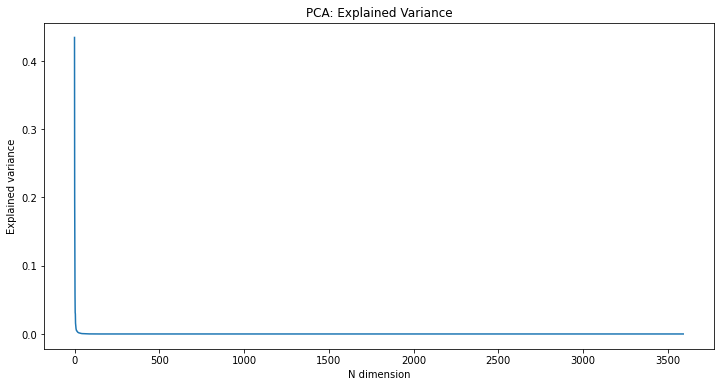

In [75]:
# "Elbow Method" plot to look at this
plt.figure(figsize=(12, 6))
plt.plot(range(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_, markersize=10)

plt.title('PCA: Explained Variance')
plt.xlabel('N dimension')
plt.ylabel('Explained variance')
plt.show()

In [76]:
# find "elbow"
kl = KneeLocator(range(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_,
                 curve="convex", direction="decreasing")

print('Elbow located at: {}'.format(kl.elbow))

Elbow located at: 24


In [77]:
# Let's keep 50 dimensions just to conservative
# how much variance do the first 50 dimensions explain?
n = 50
print('The first {} dimensions explain {:.2%} of the variance'.format(n, np.sum(pca.explained_variance_ratio_[:n])))

The first 50 dimensions explain 98.81% of the variance


In [78]:
# reduce X to the first 50 dimensions
X_reduced = np.matrix([row[:50] for row in X])
print(np.shape(X_reduced))

(3592, 50)


### K-Means Clustering
Now, we'll use the unsupervised method K means clustering to put each word (row) into a cluster of "similar" words. Each cluster can then be used as a node in a network.

This task has a lot of Researcher degrees of freedom because $k$ (the number of clusters) needs to be specified. The lower the value of $k$, the more words in each cluster -- which roughly means that clusters become more and more vague in what "concept(s)" they're reflecting.

In [79]:
# we'll use k-means clustering to identify which words are similar
# initialize our k-means algorithm

def get_kmeans(k, X):
    kmeans = KMeans(
        n_clusters=k
    )

    # run k-means!
    return kmeans.fit(X)

In [133]:
# Don't run this code, it takes for ever!

# K-Means is unsupervised, but it requires K to be specified
# iterate over potential values of k and measure how much error is produced from that value
'''
error = list() # save error for this value of k

for k in range(1,len(unique_words)): 
    if k%100 == 0:
        print('Checking k = {}'.format(k))
    kmeans = get_kmeans(k, X_reduced)
    error.append(kmeans.inertia_) # save sum of squared error (SSE)
    
print('{} values of k checked'.format(len(error)))
'''

Checking k = 100
Checking k = 200
Checking k = 300
Checking k = 400
Checking k = 500
Checking k = 600
Checking k = 700
Checking k = 800
Checking k = 900
Checking k = 1000
Checking k = 1100
Checking k = 1200
Checking k = 1300
Checking k = 1400
Checking k = 1500
Checking k = 1600
Checking k = 1700
1736 values of k checked


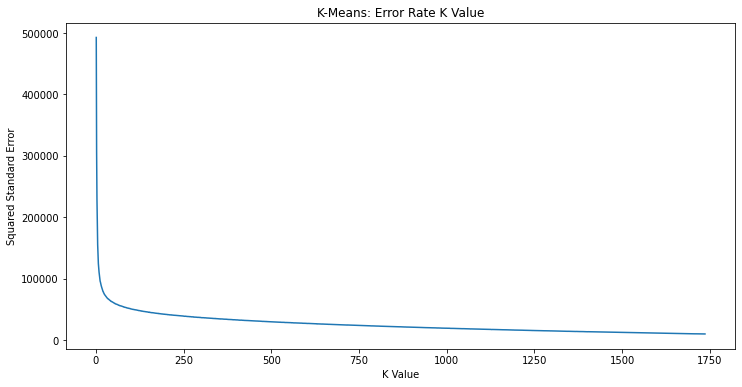

In [135]:
# Again, don't run this but you could use this code to determine a "good" number of clusters.

'''
kl = KneeLocator(range(1, len(error)+1), error, 
                 curve="convex", direction="decreasing")
print('Optimum number of clusters: {}'.format(kl.elbow))

# "Elbow Method" plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(error)+1), error, markersize=10)

# plt.xticks(np.arange(0, 21, 1))
plt.title('K-Means: Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Squared Standard Error')
plt.show()
'''

In [80]:
# Let's take k = 52 clusters
k = 52
kmeans = get_kmeans(k, X_reduced) # get our kmeans object

cluster_assignment = kmeans.labels_ # save the labels

print(cluster_assignment) # print the cluster assignments just to show
print(len(cluster_assignment)) # number of label (one for each token!)
print(len(trimmed)) # number of tokens

[28 32 13 ... 27 27 17]
3592
3592


In [81]:
# look at a random cluster
trimmed = np.array(trimmed)
trimmed[np.where(cluster_assignment==42)[0]]

array([criticisms, men, steps, promises, weeks, bodies, blows, others,
       years, jurists, years, eyes, fears, people, others, laws, laws,
       men, citizens, blocks, years, years, ills, men, workers, ways,
       ideologies, rides, ways, days, extremists, extremists, extremists,
       extremists, extremists, opponents, windows, worshipers, days,
       tears, nonconformists, days, millions, streets, times, wages,
       occasions, years, ends], dtype=object)

In [82]:
# Next, we'll name each cluster based on the most frequent word in it

# to do this, we start by creating a dictionary of words and occurance frequency
word_count = dict()

for token in trimmed:
    word_count.setdefault(token.lower_, 0)
    word_count[token.lower_] += 1
    
print(len(word_count))

1737


In [83]:
# now create two look up dictionaries

# cluster_lookup will have cluster labels (eg, 0) as keys 
# and most frequent word as the value
# we'll use this convert a cluster assignment into a text label
cluster_lookup = dict()

# size_lookup will store the text label for each cluster along with the
# total count of occurances of words in that cluster
# we'll use this to size nodes in our visualization
size_lookup = dict()

# iterate over cluster assignment values
for clust in set(cluster_assignment):
    tokens = trimmed[np.where(cluster_assignment==clust)[0]] # find the tokens for that cluster
    text = set([token.lower_ for token in tokens]) # get the text for each token
    
    # initialize things we want to track
    top_word = ''
    top_count = 0
    full_count = 0
    
    # iterate over the words in our cluster text
    for word in text:
        count = word_count[word] # retrieve frequency
        full_count += count # increment full count by this value
        
        if count > top_count: # if this count is more than we've seen previously
            top_word = word # this is now our top word
            top_count = count # this is now our top count
    
    cluster_lookup[clust] = top_word # save top word as value for this cluster
    size_lookup[top_word] = full_count # save full count as value for text label
    
# finally, we'll make one more lookup dictionary, 
# where we can lookup a textcluster assignment for a given token
token_lookup = dict((token, cluster_lookup[clust]) for token, clust in zip(trimmed, cluster_assignment))

## Build the network

Here we'll leverage SpaCy's [Dependency Parser](https://spacy.io/usage/linguistic-features) and say that word A is connected to word B if either word is the other's grammatical "head" (eg, what in the sentence is it modifying/refering to)

We'll treat each cluster as a "mega node" so if words A and B are both in the same cluster and A is connected to C and B is connected to D, our cluster-node will have edges to C and D.

In [84]:
G = nx.Graph() # empty graph

# iterate over tokens
for token in trimmed:
    
    # get cluster name
    n1 = token_lookup[token]
    
    # see if the grammatical head is a saved token
    try:
        n2 = token_lookup[token.head]
        
    except KeyError:
        n2 = 0 # if is not a saved token default to 0
        
    # add node 1 (our token) to the network
    G.add_node(n1)
    
    # if we found an edge, add it!
    if n2 != 0:
        G.add_edge(n1, n2)
        G[n1][n2].setdefault('weight', 0)
        G[n1][n2]['weight'] += 1
        
print('Network constructed')

Network constructed


In [85]:
# save just the largest connected component
G_c = max(nx.connected_components(G), key=len)

sub = G.subgraph(G_c).copy()

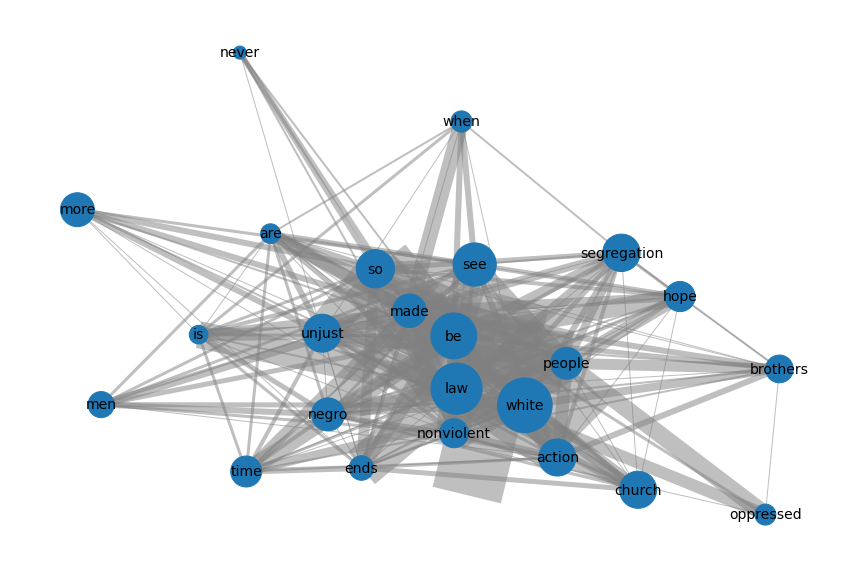

In [86]:
# visualize!

plt.figure(figsize=(12,8))
pos = nx.spring_layout(sub, seed=42) 
        
node_size = [size_lookup[node]*10 for node in sub.nodes()]
nx.draw_networkx_nodes(sub, pos, node_size=node_size)

# edges
edge_width = [details['weight'] for i, j, details in sub.edges(data=True)]
nx.draw_networkx_edges(sub, pos, width=edge_width, 
                       edge_color='grey', alpha=0.5)


# labels
nx.draw_networkx_labels(sub, pos, 
                        font_size=14)

ax = plt.gca()
ax.margins(0.1)
plt.axis("off")
plt.tight_layout()
plt.show()

# Final thoughts
There is a lot of researcher freedom in working with both text and networks -- there are **a lot** of choices about how you can define things. This means there's a lot of room for creativity but also a strong need to validate and to look carefully at your data. 

**Never take algorithmic output as object "Truth!"